In [114]:
from __future__ import print_function
from ast import Str
import scipy
import pylab
from scipy.io.wavfile import read
import sys
import peakpicker as pp
import fingerprint as fhash
import matplotlib
import numpy as np
import tdft
import os
from datetime import date, datetime


In [115]:
lala = bool.__str__(False)
os.environ['lala'] = lala

print('Start time: ', datetime.now())
# file_names = [  "song1.wav",
#                 "song2.wav",
#                 "song3.wav"]

import os

path = "D:/6th Semester/DSP/Project/Final/audio-matching/data_set"  # Replace with the actual path to the .wav files
file_names = []

for file in os.listdir(path):
    if file.endswith(".wav"):
        file_path = os.path.join(path, file)
        file_names.append(file_path)

# print(file_names)


# num_inputs = len(sys.argv)
num_inputs = len(file_names)

# Song files to be hashed into database
songs = []
songnames = []
separator = '.'

for i in range(num_inputs):
    # songs.append(read(sys.argv[i]))
    songs.append(read(file_names[i]))
    # name = sys.argv[i].split(separator,1)[0]

    
songnames = []
for file_name in file_names:
    name = os.path.splitext(os.path.basename(file_name))[0]
    songnames.append(name)
print(songnames)

Start time:  2023-06-02 11:00:03.426901
['Aankhon Aankhon (Bhaag Johnny) Yo Yo Honey Singh 320Kbps', 'Aata Majhi Satakli (Singham Returns) Yo Yo Honey Singh - 320Kbps', 'Birthday Bash - Yo Yo Honey Singh (Dilliwaali Zaalim Girlfriend) 320Kbps', 'Daftar Ki Girl (Desi Kalakaar) Yo Yo Honey Singh', 'Dheere Dheere (Yo Yo Honey Singh) - 320Kbps', 'Gal Ban Gayi - Yo Yo Honey Singh 320Kbps', 'High Heels - Ki and Ka (Yo Yo Honey Singh) 320Kbps', 'Manali Trance - Yo Yo Honey Singh (The Shaukeen) - 320kbps', 'One Bottle Down - Yo Yo Honey Singh 320Kbps', 'Superman - Zorawar - Yo Yo Honey Singh 320Kbps']


In [106]:
# TDFT parameters
windowsize = 0.008  # set the window size  (0.008s = 64 samples)
windowshift = 0.004  # set the window shift (0.004s = 32 samples)
# set the fft size (if srate = 8000, 1024 --> 513 freq. bins separated by 7.797 Hz from 0 to 4000Hz)
fftsize = 1024

# Peak picking dimensions
f_dim1 = 30
t_dim1 = 80
f_dim2 = 10
t_dim2 = 20
percentile = 70
# lowest frequency bin used (peaks below are too common/not as useful for identification)
base = 70
high_peak_threshold = 75
low_peak_threshold = 60

# Hash parameters
delay_time = 250      # 250*0.004 = 1 second
delta_time = 250*3    # 750*0.004 = 3 seconds
delta_freq = 128      # 128*7.797Hz = approx 1000Hz

# Time pair parameters
TPdelta_freq = 4
TPdelta_time = 2

# Construct the audio database of hashes
database = np.zeros((1, 5))
spectrodata = []
peaksdata = []


In [107]:
for i in range(0, len(songs)):
    print('Analyzing '+str(songnames[i]))
    srate = songs[i][0]  # sample rate in samples/second
    audio = songs[i][1]  # audio data
    spectrogram = tdft.tdft(audio, srate, windowsize, windowshift, fftsize)
    time = spectrogram.shape[0]
    freq = spectrogram.shape[1]

    threshold = pp.find_thres(spectrogram, percentile, base)

    print('The size of the spectrogram is time: ' +
          str(time)+' and freq: '+str(freq))
    spectrodata.append(spectrogram)

    peaks = pp.peak_pick(spectrogram, f_dim1, t_dim1,
                         f_dim2, t_dim2, threshold, base)

    print('The initial number of peaks is:'+str(len(peaks)))
    peaks = pp.reduce_peaks(
        peaks, fftsize,high_peak_threshold, low_peak_threshold)

    print('The reduced number of peaks is:'+str(len(peaks)))
    peaksdata.append(peaks)

    # Calculate the hashMatrix for the database song file
    songid = i
    hashMatrix = fhash.hashPeaks(
        peaks, songid, delay_time, delta_time, delta_freq)

    # Add the song hash matrix to the database
    database = np.concatenate((database, hashMatrix), axis=0)
    print('Song {} analyzed: {}'.format(songnames[i], datetime.now()))

print('The dimensions of the database hash matrix: '+str(database.shape))
database = database[np.lexsort(
    (database[:, 2], database[:, 1], database[:, 0]))]



Analyzing Aankhon Aankhon (Bhaag Johnny) Yo Yo Honey Singh 320Kbps


c:\Users\ahsan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\scimath.py:346: RuntimeWarning: divide by zero encountered in log10
  return nx.log10(x)


The size of the spectrogram is time: 61362 and freq: 513
The initial number of peaks is:406
The reduced number of peaks is:161
Song Aankhon Aankhon (Bhaag Johnny) Yo Yo Honey Singh 320Kbps analyzed: 2023-06-02 05:59:55.872838
Analyzing Aata Majhi Satakli (Singham Returns) Yo Yo Honey Singh - 320Kbps
The size of the spectrogram is time: 48608 and freq: 513
The initial number of peaks is:566
The reduced number of peaks is:199
Song Aata Majhi Satakli (Singham Returns) Yo Yo Honey Singh - 320Kbps analyzed: 2023-06-02 06:00:05.442514
Analyzing Birthday Bash - Yo Yo Honey Singh (Dilliwaali Zaalim Girlfriend) 320Kbps
The size of the spectrogram is time: 63169 and freq: 513
The initial number of peaks is:958
The reduced number of peaks is:320
Song Birthday Bash - Yo Yo Honey Singh (Dilliwaali Zaalim Girlfriend) 320Kbps analyzed: 2023-06-02 06:00:16.832966
Analyzing Daftar Ki Girl (Desi Kalakaar) Yo Yo Honey Singh
The size of the spectrogram is time: 50140 and freq: 513
The initial number of pe

In [74]:
# import sounddevice as sd
# import soundfile as sf

# # Set the parameters for recording audio from the microphone
# duration = 10  # Specify the duration of the recording in seconds
# samplerate = 44100  # Specify the sample rate (e.g., 44100 Hz)

# # Record audio from the microphone
# print('Recording audio for 10 seconds...')
# audio = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1)
# sd.wait()  # Wait until the recording is complete

# # Save the recorded audio to a .wav file
# output_file = 'recorded_audio.wav'
# sf.write(output_file, audio, samplerate)

# print('Audio saved successfully.')


In [75]:
# import sounddevice as sd
# import scipy.io.wavfile as wav

# # Specify the path to the WAV file
# wav_file = output_file

# # Read the WAV file
# sample_rate, audio_data = wav.read(wav_file)

# # Play the audio
# sd.play(audio_data, sample_rate)
# sd.wait()  # Wait until the audio is finished playing


In [76]:
# # python -m pip install pyaudio
# import pyaudio
# import wave
# import matplotlib.pyplot as plt
# import numpy as np

# FRAMES_PER_BUFFER = 3200
# FORMAT = pyaudio.paInt16
# CHANNELS = 1
# RATE = 16000

# pa = pyaudio.PyAudio()

# stream = pa.open(
#     format=FORMAT,
#     channels=CHANNELS,
#     rate=RATE,
#     input=True,
#     frames_per_buffer=FRAMES_PER_BUFFER
# )

# print('start recording')

# seconds = 8
# frames = []
# second_tracking = 0
# second_count = 0
# for i in range(0, int(RATE/FRAMES_PER_BUFFER*seconds)):
#     data = stream.read(FRAMES_PER_BUFFER)
#     frames.append(data)
#     second_tracking += 1
#     if second_tracking == RATE/FRAMES_PER_BUFFER:
#         second_count += 1
#         second_tracking = 0
#         print(f'Time Left: {seconds - second_count} seconds')


# stream.stop_stream()
# stream.close()
# pa.terminate()

# obj = wave.open('case.wav', 'wb')
# obj.setnchannels(CHANNELS)
# obj.setsampwidth(pa.get_sample_size(FORMAT))
# obj.setframerate(RATE)
# obj.writeframes(b''.join(frames))
# obj.close()


# file = wave.open('case.wav', 'rb')

# sample_freq = file.getframerate()
# frames = file.getnframes()
# signal_wave = file.readframes(-1)

# file.close()

# time = frames / sample_freq


# # if one channel use int16, if 2 use int32
# audio_array = np.frombuffer(signal_wave, dtype=np.int16)

# times = np.linspace(0, time, num=frames)

# plt.figure(figsize=(15, 5))
# plt.plot(times, audio_array)
# plt.ylabel('Signal Wave')
# plt.xlabel('Time (s)')
# plt.xlim(0, time)
# plt.title('The Thing I Just Recorded!!')
# plt.show()

In [109]:
import sounddevice as sd
import soundfile as sf
from pydub import AudioSegment

# Set the parameters for recording audio from the microphone
duration = 20  # Specify the duration of the recording in seconds
samplerate = 44100  # Specify the sample rate (e.g., 44100 Hz)

# Record audio from the microphone
print('Recording audio for 20 seconds...')
audio = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=2)
sd.wait()  # Wait until the recording is complete

# Save the recorded audio to a WAV file
output_wav = 'recorded_audio.wav'
sf.write(output_wav, audio, samplerate)




Recording audio for 20 seconds...


In [78]:
# from pydub import AudioSegment

# # Specify the input audio file
# input_file = "recorded_audio.wav"

# # Load the audio file
# audio = AudioSegment.from_file(input_file)

# # Set the output file path and format
# output_file = "output_audio.wav"

# # Export the audio in .wav format
# audio.export(output_file, format="wav")

# print("Audio file converted to .wav successfully.")


In [110]:
print('Please enter an audio sample file to identify: ')
# userinput = raw_input('---> ')
userinput = 'recorded_audio.wav'
# userinput = 'CanICallYouTonight_Live_1.wav'
# userinput = 'YoQuisiera_Live.wav'
sample = read(userinput)
userinput = userinput.split(separator, 1)[0]
print('Analyzing the audio sample: '+str(userinput), datetime.now())
srate = sample[0]  # sample rate in samples/second
audio = sample[1]  # audio data
lala = "True"
spectrogram = tdft.tdft(audio, srate, windowsize, windowshift, fftsize)
time = spectrogram.shape[0]
freq = spectrogram.shape[1]
print('The size of the spectrogram is time: ' +
      str(time)+' and freq: '+str(freq))
threshold = pp.find_thres(spectrogram, percentile, base)
peaks = pp.peak_pick(spectrogram, f_dim1, t_dim1,
                     f_dim2, t_dim2, threshold, base)
print('The initial number of peaks is:'+str(len(peaks)))
peaks = pp.reduce_peaks(
    peaks, fftsize, high_peak_threshold, low_peak_threshold)
print('The reduced number of peaks is:'+str(len(peaks)))

Please enter an audio sample file to identify: 
Analyzing the audio sample: recorded_audio 2023-06-02 06:03:06.966665
The size of the spectrogram is time: 5010 and freq: 513
The initial number of peaks is:73
The reduced number of peaks is:26


In [111]:
# Read the WAV file
sample_rate, audio_data = wav.read('recorded_audio.wav')

# Play the audio
sd.play(audio_data, sample_rate)
sd.wait()  # Wait until the audio is finished playing

In [112]:
# Store information for the spectrogram graph
samplePeaks = peaks
sampleSpectro = spectrogram

hashSample = fhash.hashSamplePeaks(
    peaks, delay_time, delta_time, delta_freq)
print('The dimensions of the hash matrix of the sample: '+str(hashSample.shape))

print('Attempting to identify the sample audio clip.')
timepairs = fhash.findTimePairs(
    database, hashSample, TPdelta_freq, TPdelta_time)

# Compute the number of matches by song id to determine a match
numSongs = len(songs)
songbins = np.zeros(numSongs)
numOffsets = len(timepairs)
offsets = np.zeros(numOffsets)
index = 0
for i in timepairs:
    offsets[index] = i[0]-i[1]
    index = index+1
    songbins[int(i[2])] += 1

# Identify the song
print('The sample song is: ' +
      str(songnames[np.argmax(songbins)]), datetime.now())


The dimensions of the hash matrix of the sample: (51, 4)
Attempting to identify the sample audio clip.
The sample song is: Gal Ban Gayi - Yo Yo Honey Singh 320Kbps 2023-06-02 06:03:32.899126


C:\Users\ahsan\AppData\Local\Temp\ipykernel_7568\3883459103.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  i.show()
C:\Users\ahsan\AppData\Local\Temp\ipykernel_7568\3883459103.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

C:\Users\ahsan\AppData\Local\Temp\ipykernel_7568\3883459103.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


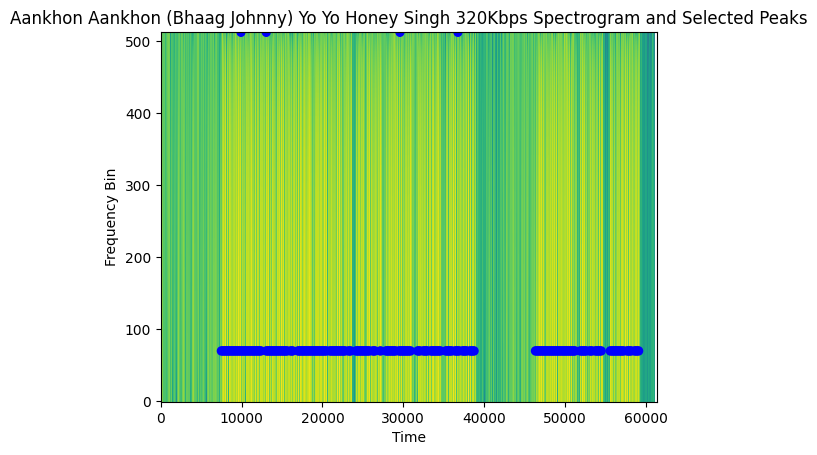

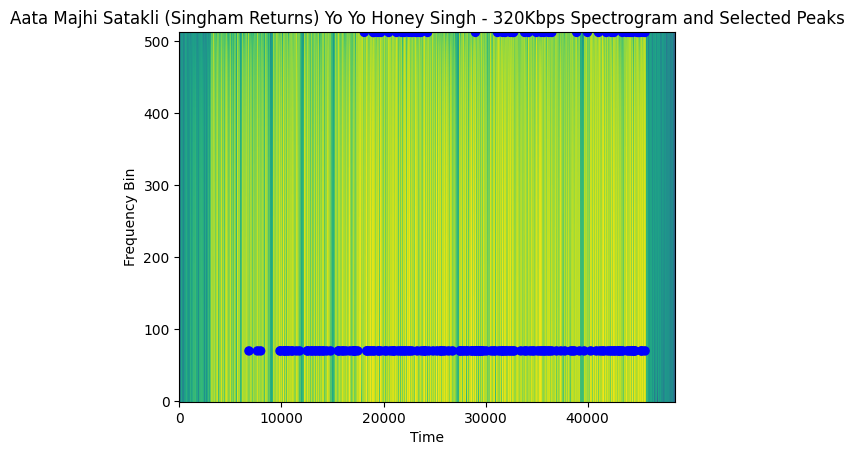

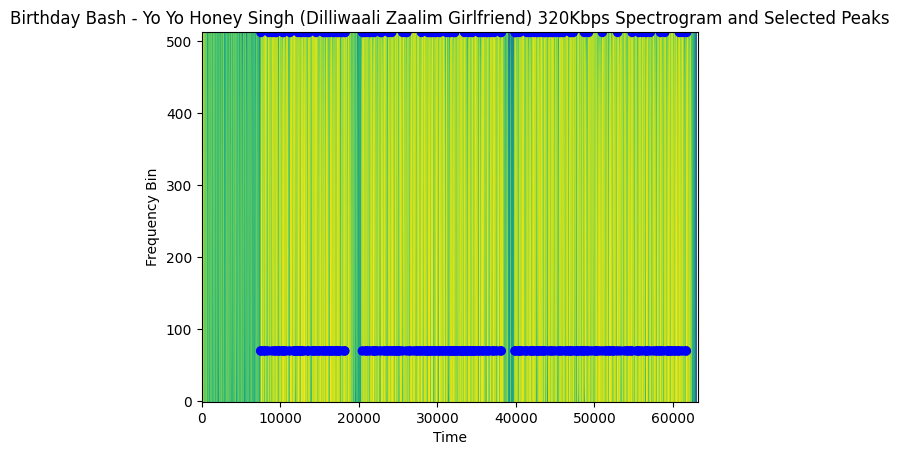

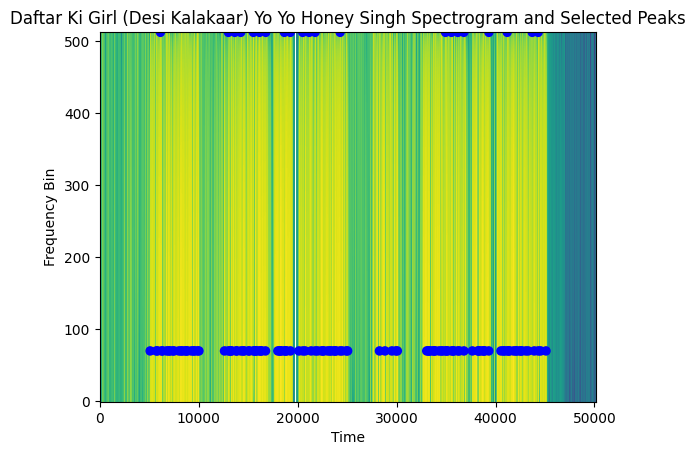

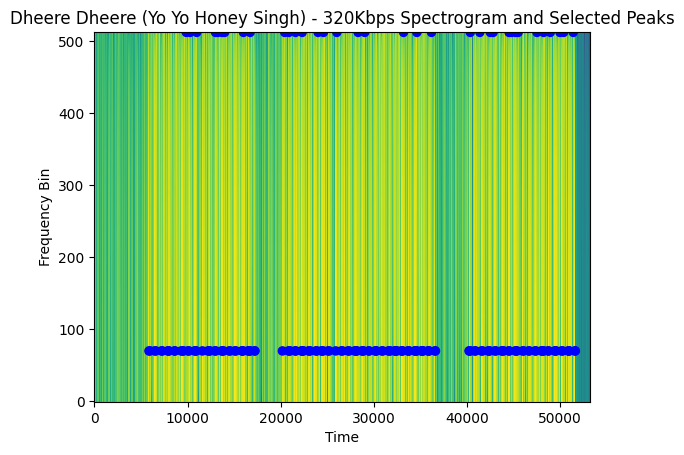

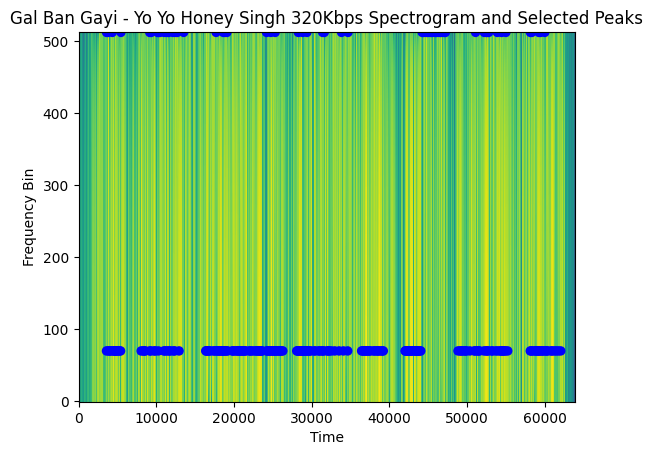

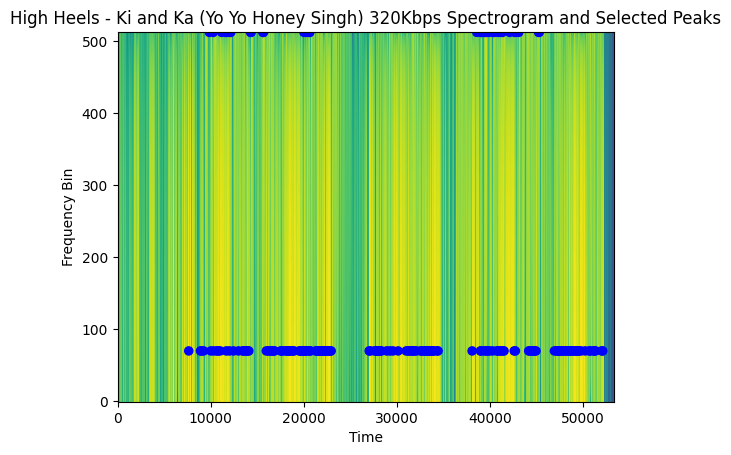

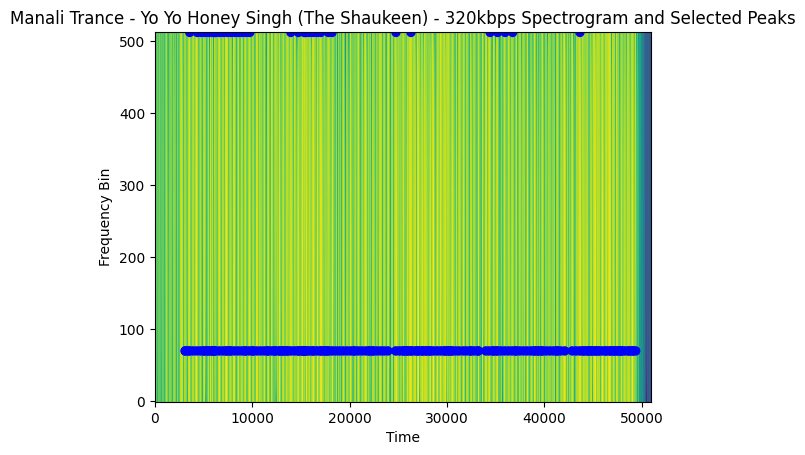

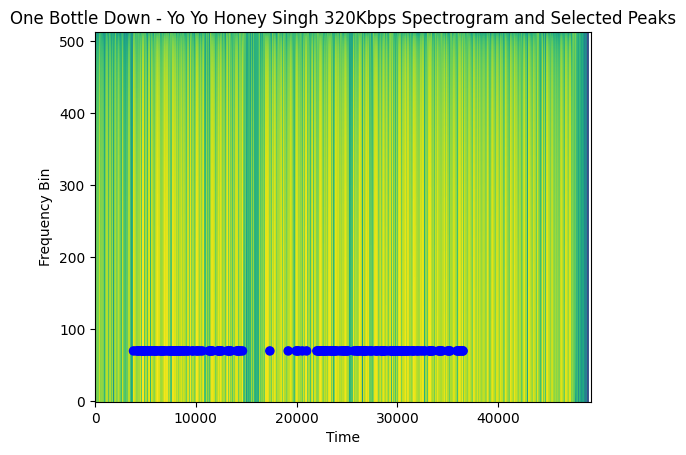

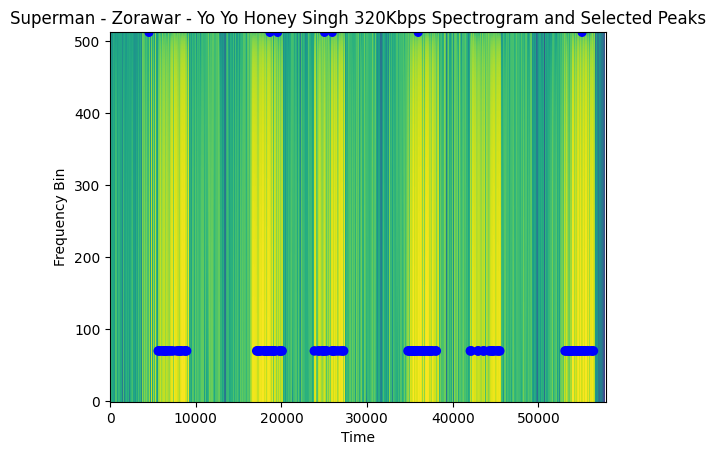

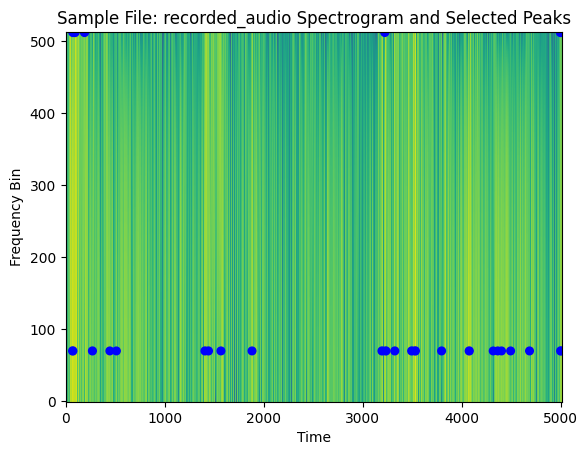

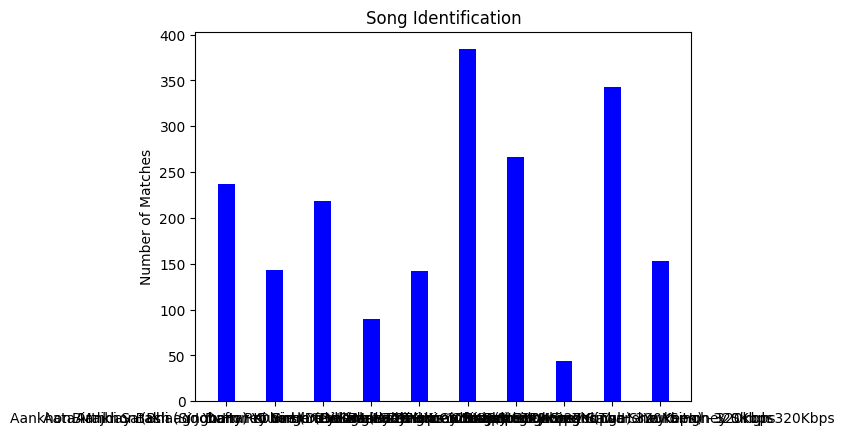

The sample song is: Gal Ban Gayi - Yo Yo Honey Singh 320Kbps


In [113]:
# Plots
fig = []

# Plot the magnitude spectrograms
for i in range(0, numSongs):
        fig1 = pylab.figure(i)
        peaks = peaksdata[i]
        pylab.imshow(spectrodata[i].T, origin='lower',
                     aspect='auto', interpolation='nearest')
        pylab.scatter(*zip(*peaks), marker='.', color='blue')
        pylab.title(str(songnames[i])+' Spectrogram and Selected Peaks')
        pylab.xlabel('Time')
        pylab.ylabel('Frequency Bin')
        fig.append(fig1)

# Show the figures
for i in fig:
    i.show()
fig2 = pylab.figure(1002)
pylab.imshow(sampleSpectro.T, origin='lower',
             aspect='auto', interpolation='nearest')
pylab.scatter(*zip(*samplePeaks), marker='.', color='blue')
pylab.title('Sample File: '+str(userinput) +
            ' Spectrogram and Selected Peaks')
pylab.xlabel('Time')
pylab.ylabel('Frequency Bin')
fig2.show()
fig3 = pylab.figure(1003)
ax = fig3.add_subplot(111)
ind = np.arange(numSongs)
width = 0.35
rects1 = ax.bar(ind, songbins, width, color='blue', align='center')
ax.set_ylabel('Number of Matches')
ax.set_xticks(ind)
xtickNames = ax.set_xticklabels(songnames)
matplotlib.pyplot.setp(xtickNames)
pylab.title('Song Identification')
fig3.show()
pylab.show()
print('The sample song is: '+str(songnames[np.argmax(songbins)]))